In [1]:
from rnamodif.data_utils.dataloading import get_test_dataset
from rnamodif.data_utils.datamap import experiment_files
import torch
from rnamodif.evaluation.evaluation import run_test
from rnamodif.architectures.rodan_pretrained_MIL import RodanPretrainedMIL

#TODO do only valid split?
def get_dsets_preds(checkpoint):
    workers=4
    architecture=RodanPretrainedMIL
    window=4096
    stride = 2048
    batch_size=64
    
    test_dset_covid0 = get_test_dataset(experiment_files['m6A_0_covid'], window=window, normalization='rodan', trim_primer=False, stride=stride)
    predictions_covid0 = run_test(test_dset_covid0,checkpoint=checkpoint, workers=workers, architecture=architecture, batch_size=batch_size)

    test_dset_covid5 = get_test_dataset(experiment_files['m6A_5_covid'], window=window, normalization='rodan', trim_primer=False, stride=stride)
    predictions_covid5 = run_test(test_dset_covid5,checkpoint=checkpoint, workers=workers, architecture=architecture, batch_size=batch_size)

    test_dset_covid10 = get_test_dataset(experiment_files['m6A_10_covid'], window=window, normalization='rodan', trim_primer=False, stride=stride)
    predictions_covid10 = run_test(test_dset_covid10,checkpoint=checkpoint, workers=workers, architecture=architecture, batch_size=batch_size)

    test_dset_covid33 = get_test_dataset(experiment_files['m6A_33_covid'], window=window, normalization='rodan', trim_primer=False, stride=stride)
    predictions_covid33 = run_test(test_dset_covid33,checkpoint=checkpoint, workers=workers, architecture=architecture, batch_size=batch_size)

    test_dset_novoa_1 = get_test_dataset(experiment_files['m6a_novoa_1'], window=window, normalization='rodan', trim_primer=False, stride=stride)
    predictions_novoa_1 = run_test(test_dset_novoa_1,checkpoint=checkpoint, workers=workers, architecture=architecture, batch_size=batch_size)

    test_dset_novoa_2 = get_test_dataset(experiment_files['m6a_novoa_2'], window=window, normalization='rodan', trim_primer=False, stride=stride)
    predictions_novoa_2 = run_test(test_dset_novoa_2,checkpoint=checkpoint, workers=workers, architecture=architecture, batch_size=batch_size)

    test_dset_unm_1 = get_test_dataset(experiment_files['UNM_novoa_1'], window=window, normalization='rodan', trim_primer=False, stride=stride)
    predictions_novoa_unm_1 = run_test(test_dset_unm_1,checkpoint=checkpoint, workers=workers, architecture=architecture, batch_size=batch_size)

    test_dset_unm_2 = get_test_dataset(experiment_files['UNM_novoa_2'], window=window, normalization='rodan', trim_primer=False, stride=stride)
    predictions_novoa_unm_2 = run_test(test_dset_unm_2,checkpoint=checkpoint, workers=workers, architecture=architecture, batch_size=batch_size)

    test_dset_unm_short = get_test_dataset(experiment_files['UNM_novoa_short'], window=window, normalization='rodan', trim_primer=False, stride=stride)
    predictions_novoa_unm_short = run_test(test_dset_unm_short,checkpoint=checkpoint, workers=workers, architecture=architecture, batch_size=batch_size)

    dsets_preds = [(predictions_covid0,0,'covid 0'), (predictions_covid5,1,'covid 5'),
                   (predictions_covid10,1,'covid 10'),(predictions_covid33,1,'covid 33'),
                  (predictions_novoa_1, 1,'novoa 1'), (predictions_novoa_2, 1,'novoa 2'), 
                   (predictions_novoa_unm_1, 0,'novoa UNM 1'), (predictions_novoa_unm_2, 0,'novoa UNM 2'),
                  (predictions_novoa_unm_short, 0,'novoa UNM short')]
    return dsets_preds

In [42]:
import numpy as np
from matplotlib import pyplot as plt

def predictions_to_read_predictions(predictions):
    agg_preds = []
    read_ids = []
    for preds, ids in predictions:
        agg_preds.append(preds.numpy())
        read_ids.append(ids['readid'])
    read_ids = np.concatenate(read_ids)
    agg_preds = np.concatenate(agg_preds)
    results = {}
    for un_read_id in np.unique(read_ids):
        indicies = np.where(read_ids == un_read_id)
        # print(agg_preds[indicies])
        results[un_read_id] = agg_preds[indicies]
        # read_ids
    return results
    

def get_metrics(read_predictions, label, mean_threshold=0.5, max_threshold=0.9):
    mean_accs = []
    max_accs = []
    
    for k,v in read_predictions.items():
        if(label == 1):
            mean_accs.append(np.mean(v) > mean_threshold)
            max_accs.append(np.max(v) > max_threshold)
        else:
            mean_accs.append(np.mean(v) < mean_threshold)
            max_accs.append(np.max(v) < max_threshold)
    mean_based_acc = np.mean(mean_accs)
    max_based_acc = np.mean(max_accs)
    print('mean based', mean_based_acc)
    print('max based', max_based_acc)
    return mean_based_acc, max_based_acc




def test_thresholds(dsets_preds, mean_threshold, max_threshold):
    me_t = mean_threshold #0.35
    ma_t = max_threshold #0.75 
    means = []
    maxes = []
    for preds, label, dset in dsets_preds:
        # print('_______')
        print(dset)
        res = predictions_to_read_predictions(preds)
        mean_based, max_based = get_metrics(res, label=label, mean_threshold=me_t, max_threshold=ma_t)
        means.append(mean_based)
        maxes.append(max_based)
    print('-------------')
    print('MEAN BASED ACC', np.mean(means))
    print('MAX BASED ACC', np.mean(maxes))
    print('mean based covid', np.mean(means[:4]))
    print('mean based novoa', np.mean(means[4:]))

    print('max based covid', np.mean(maxes[:4]))
    print('max based novoa', np.mean(maxes[4:]))


def get_decision_points(dsets_preds, max_threshold):
    correct_decisions = []
    wrong_decisions = []
    
    for preds, label, dset in dsets_preds:
        res = predictions_to_read_predictions(preds)
        for k,v in res.items():
            predicted_label = np.max(v) > max_threshold
            decision_index = np.argmax(v)/len(v)
            # print(np.argwhere(v > max_threshold))
            # raise Exception()
            if(label ==1): #Only positives
                if(predicted_label == label):
                    correct_decisions.append(decision_index)
                else:
                    wrong_decisions.append(decision_index)
            
    plt.hist(correct_decisions, color='green')
    plt.hist(wrong_decisions, color='red')
    plt.show()


In [3]:
from sklearn import metrics
from matplotlib import pyplot as plt

def plot_roc(dsets_preds, pooling='max'):
    predictions = []
    labels = []
    exps = []
    for log in dsets_preds:
        preds, label, exp = log
        exps.append(exp)
        preds = predictions_to_read_predictions(preds)
        mod_probs = []
        for k,v in preds.items():
            if(pooling == 'max'):
                mod_probability = np.max(v)
            elif(pooling == 'mean'):
                mod_probability = np.mean(v)
            else:
                raise Exception('pooling unspecified')
            mod_probs.append(mod_probability)
        predictions = predictions + mod_probs
        labels = labels + [label]*len(mod_probs)

    # print(predictions)
    # print(labels)

    fpr, tpr, thresholds = metrics.roc_curve(labels, predictions)
    cutoff_1 = thresholds[np.argmax(tpr-fpr)]
    cutoff_1_tpr = tpr[np.argmax(tpr-fpr)]
    
    cutoff_2 = thresholds[np.argmin((1-tpr) ** 2 + fpr ** 2)]
    cutoff_2_tpr = tpr[np.argmin((1-tpr) ** 2 + fpr ** 2)]
    
    auc = metrics.roc_auc_score(labels, predictions)
    plt.plot(fpr, tpr, label = f'{exps} \n AUC %.3f CUTOFFS {str(cutoff_1)[:4]} (tpr {str(cutoff_1_tpr)[:4]}) or {str(cutoff_2)[:4]} (tpr {str(cutoff_2_tpr)[:4]})' % auc)
    plt.title(pooling)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

In [4]:
def plot_covid_roc(dsets_preds):
    plot_roc([dsets_preds[i] for i in [0,1]], pooling='max')
    plot_roc([dsets_preds[i] for i in [0,2]], pooling='max')
    plot_roc([dsets_preds[i] for i in [0,3]], pooling='max')
    plt.show()
    plot_roc([dsets_preds[i] for i in [0,1]], pooling='mean')
    plot_roc([dsets_preds[i] for i in [0,2]], pooling='mean')
    plot_roc([dsets_preds[i] for i in [0,3]], pooling='mean')
    plt.show()


In [5]:
def plot_roc_curves(dsets_preds):
    pooling = 'max'
    plot_roc(dsets_preds, pooling=pooling)
    plot_roc(dsets_preds[:4], pooling=pooling)
    plot_roc(dsets_preds[4:], pooling=pooling)
    plt.show()
    #Balance data?
    pooling = 'mean'
    plot_roc(dsets_preds, pooling=pooling)
    plot_roc(dsets_preds[:4], pooling=pooling)
    plot_roc(dsets_preds[4:], pooling=pooling)
    plt.show()

In [6]:
import pickle
#TODO bigger btch size?
mix_preds = get_dsets_preds(checkpoint='/home/jovyan/RNAModif/rnamodif/checkpoints_pl/m6a_nih_mix_deploy/epoch=0-step=557500.ckpt')
zero33_preds = get_dsets_preds(checkpoint='/home/jovyan/RNAModif/rnamodif/checkpoints_pl/m6a_nih_33_deploy/epoch=0-step=443500.ckpt')

with open('mix_preds.pkl', 'wb') as f:
    pickle.dump(mix_preds, f)
    
with open('zero33_preds.pkl', 'wb') as f:
    pickle.dump(zero33_preds, f)


LIMITED!!!!!!!!!!!!1


/home/jovyan/my-conda-envs/RNAmodEnvRod/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:93: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

dset has 7 files
dset has 7 files
dset has 7 filesdset has 9 files



/home/jovyan/my-conda-envs/RNAmodEnvRod/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


LIMITED!!!!!!!!!!!!1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

dset has 7 files
dset has 7 files
dset has 7 files
dset has 7 files
LIMITED!!!!!!!!!!!!1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

dset has 8 files
dset has 8 files
dset has 8 files
dset has 9 files
LIMITED!!!!!!!!!!!!1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

dset has 5 files
dset has 5 files
dset has 5 files
dset has 7 files
LIMITED!!!!!!!!!!!!1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

dset has 33593 files
dset has 33593 files
dset has 33593 files
dset has 33595 files
LIMITED!!!!!!!!!!!!1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

dset has 159715 files
dset has 159715 files
dset has 159715 files
dset has 159715 files
LIMITED!!!!!!!!!!!!1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

dset has 16684 files
dset has 16684 files
dset has 16684 files
dset has 16684 files
LIMITED!!!!!!!!!!!!1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

dset has 211648 files
dset has 211648 files
dset has 211648 files
dset has 211651 files
LIMITED!!!!!!!!!!!!1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

dset has 5 files
dset has 5 files
dset has 5 files
dset has 5 files
LIMITED!!!!!!!!!!!!1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

dset has 7 files
dset has 7 files
dset has 7 files
dset has 9 files
LIMITED!!!!!!!!!!!!1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

dset has 7 files
dset has 7 files
dset has 7 files
dset has 7 files
LIMITED!!!!!!!!!!!!1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

dset has 8 files
dset has 8 files
dset has 8 files
dset has 9 files
LIMITED!!!!!!!!!!!!1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

dset has 5 files
dset has 5 files
dset has 5 files
dset has 7 files
LIMITED!!!!!!!!!!!!1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

dset has 33593 files
dset has 33593 files
dset has 33593 files
dset has 33595 files
LIMITED!!!!!!!!!!!!1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

dset has 159715 files
dset has 159715 files
dset has 159715 files
dset has 159715 files
LIMITED!!!!!!!!!!!!1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

dset has 16684 files
dset has 16684 files
dset has 16684 files
dset has 16684 files
LIMITED!!!!!!!!!!!!1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

dset has 211648 files
dset has 211648 files
dset has 211648 files
dset has 211651 files
LIMITED!!!!!!!!!!!!1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

dset has 5 files
dset has 5 files
dset has 5 files
dset has 5 files


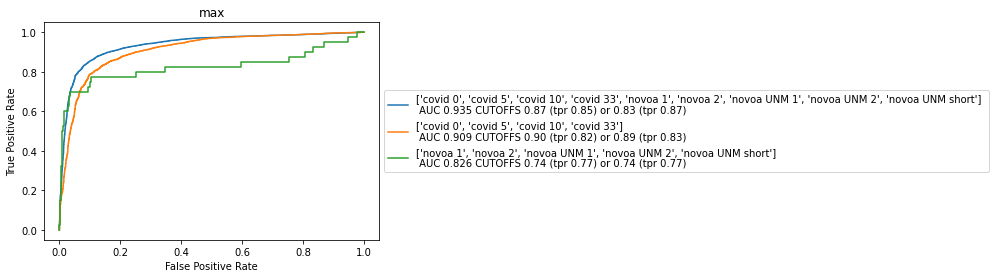

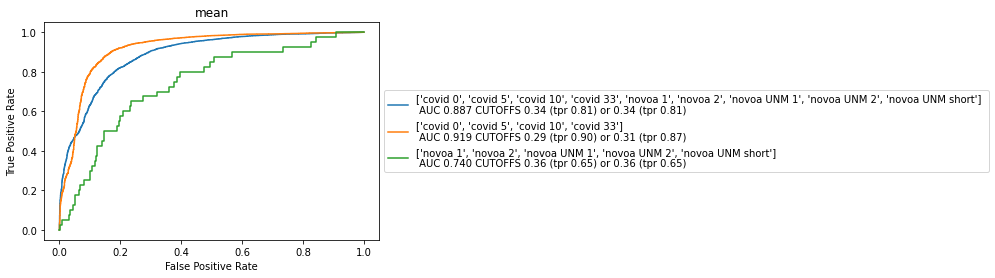

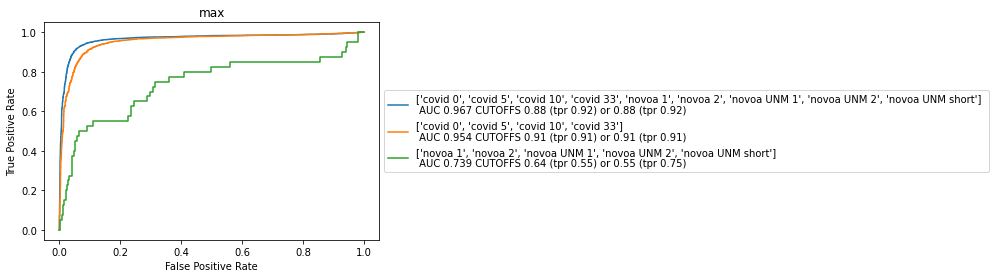

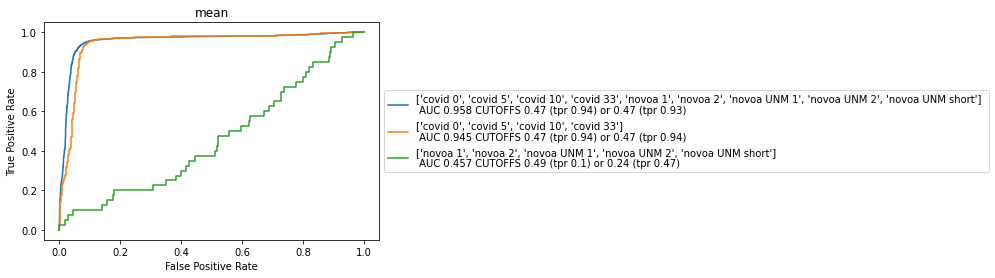

In [65]:
plot_roc_curves(zero33_preds)
plot_roc_curves(mix_preds)

In [53]:
# plot_covid_roc(mix_preds)
# plot_covid_roc(zero33_preds)

In [51]:
test_thresholds(zero33_preds, mean_threshold=0.33, max_threshold=0.85)

covid 0
mean based 0.868
max based 0.803
covid 5
mean based 0.6995
max based 0.773
covid 10
mean based 0.879
max based 0.874
covid 33
mean based 0.9735
max based 0.9615
novoa 1
mean based 0.8
max based 0.75
novoa 2
mean based 0.6
max based 0.65
novoa UNM 1
mean based 0.6
max based 0.4
novoa UNM 2
mean based 0.45
max based 0.55
novoa UNM short
mean based 0.669
max based 0.974
-------------
MEAN BASED ACC 0.7265555555555555
MAX BASED ACC 0.7483888888888889
mean based covid 0.855
mean based novoa 0.6238
max based covid 0.852875
max based novoa 0.6648


In [55]:
test_thresholds(mix_preds, mean_threshold=0.33, max_threshold=0.85)

covid 0
mean based 0.3195
max based 0.84
covid 5
mean based 0.986
max based 0.9555
covid 10
mean based 0.9785
max based 0.9355
covid 33
mean based 0.985
max based 0.9485
novoa 1
mean based 0.2
max based 0.15
novoa 2
mean based 0.2
max based 0.1
novoa UNM 1
mean based 0.65
max based 0.9
novoa UNM 2
mean based 0.65
max based 0.75
novoa UNM short
mean based 0.79
max based 0.9915
-------------
MEAN BASED ACC 0.639888888888889
MAX BASED ACC 0.730111111111111
mean based covid 0.8172499999999999
mean based novoa 0.49800000000000005
max based covid 0.919875
max based novoa 0.5782999999999999


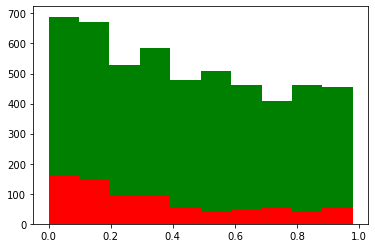

In [63]:
get_decision_points(zero33_preds, max_threshold=0.85)

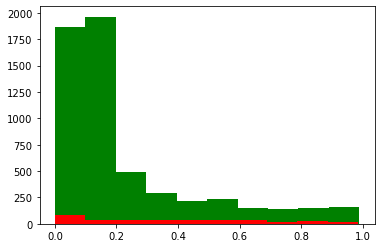

In [64]:
get_decision_points(mix_preds, max_threshold=0.85)
#Deciting on primers, OR mods are at the beginning mostly for 10and5 percent m6a